## Spike-based motion estimation

Tutorial notebook for estimating motion from spikes.
This is a bit temporary, since the AP code will be updated into spikeinterface soon.

This is an updated version of spikeinterface's notebook https://spikeinterface.github.io/blog/spikeinterface-motion-estimation/ which does have a little more stuff.
Like that notebook, here we also use one of the induced motion datasets (probe p1 of dataset1 from Steinmetz et al 2021) https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# we use spikeinterface for all things preprocessing and data handling now
import spikeinterface.full as si
# AP registration lives here for now
from dredge.dredge_ap import register
# this has some helpers for plotting
import dredge.motion_util as mu

# spikeinterface peak detection + localization
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

/mnt/home/cwindolf/my_spikeinterface/spikeinterface/sortingcomponents/peak_detection.py:402: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=False)
/mnt/home/cwindolf/my_spikeinterface/spikeinterface/sortingcomponents/peak_detection.py:424: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=False)


In [2]:
# a very basic preprocessing, used only for demo purposes
rec = si.read_spikeglx("/mnt/home/cwindolf/ceph/dataset1")
# restrict to channels with activity in this recording
rec = rec.channel_slice(rec.channel_ids[:300])
rec = si.bandpass_filter(rec)
rec = si.common_reference(rec)
rec = si.zscore(rec)
# optional
rec = rec.save_to_folder("/tmp/scratch", n_jobs=4)

Use cache_folder=/tmp/scratch
write_binary_recording with n_jobs = 4 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1958 [00:00<?, ?it/s]

In [3]:
peaks = detect_peaks(
    rec,
    method="locally_exclusive",
    detect_threshold=6,
    peak_sign="both",
    n_jobs=-1,
)

detect peaks:   0%|          | 0/1958 [00:00<?, ?it/s]

In [7]:
peak_locations = localize_peaks(
    rec,
    peaks,
    method="monopolar_triangulation",
    local_radius_um=75,
    n_jobs=10,
)

localize peaks:   0%|          | 0/1958 [00:00<?, ?it/s]

In [8]:
t_seconds = peaks['sample_ind'] / 30_000
amplitude = np.abs(peaks['amplitude'])
depth_um = peak_locations['y']

In [9]:
raster, depth_bin_edges, time_bin_edges = mu.spike_raster(amplitude, depth_um, t_seconds)

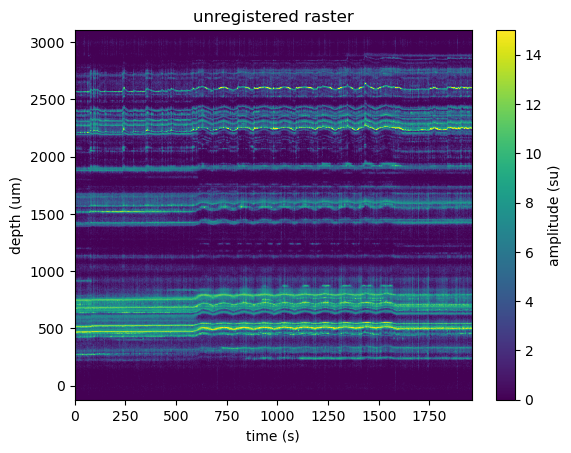

In [19]:
mu.show_raster(raster, depth_bin_edges, time_bin_edges, plt, vmax=15, aspect="auto")
plt.colorbar(label="amplitude (su)")
plt.title("unregistered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)");

In [16]:
# run nonrigid registration
motion_est, extra_info = register(
    amplitude,
    depth_um,
    t_seconds,
    win_scale_um=800,
)

Cross correlation:   0%|          | 0/7 [00:00<?, ?it/s]

Weights:   0%|          | 0/7 [00:00<?, ?it/s]

Text(0, 0.5, 'depth (um)')

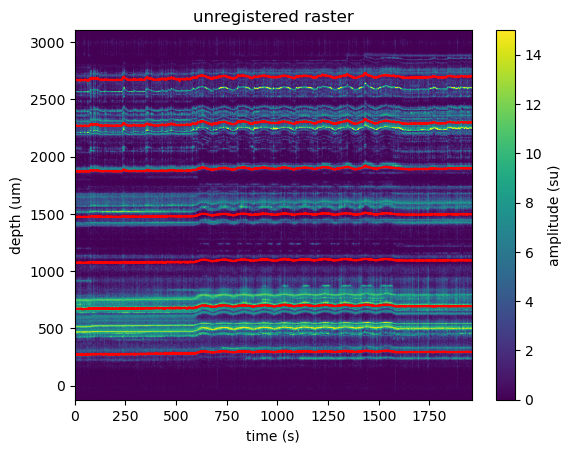

In [18]:
mu.show_raster(raster, depth_bin_edges, time_bin_edges, plt, vmax=15, aspect="auto")
mu.plot_me_traces(motion_est, plt, c="r")
plt.colorbar(label="amplitude (su)")
plt.title("unregistered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)")

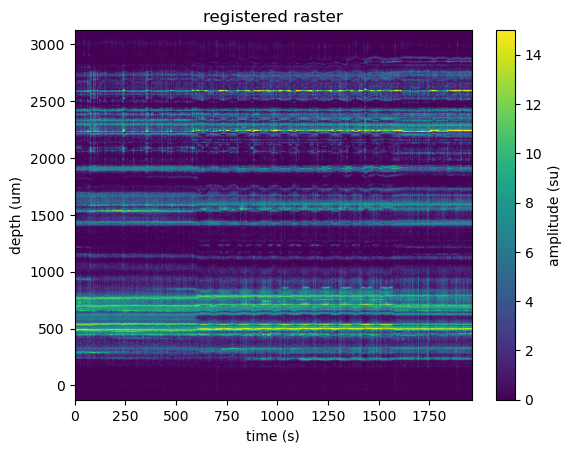

In [21]:
mu.show_registered_raster(motion_est, amplitude, depth_um, t_seconds, plt, vmax=15, aspect="auto")
plt.colorbar(label="amplitude (su)")
plt.title("registered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)");

In [22]:
# rigid registration
motion_est_rigid, extra_info_rigid = register(
    amplitude,
    depth_um,
    t_seconds,
    rigid=True,
)

Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Weights:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'depth (um)')

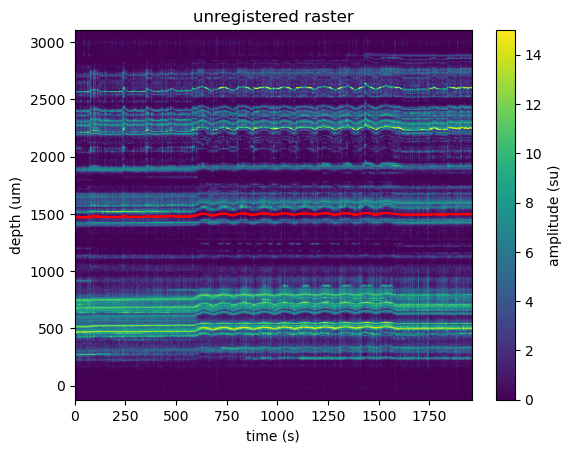

In [30]:
fig, ax = plt.subplots()
mu.show_raster(raster, depth_bin_edges, time_bin_edges, plt, vmax=15, aspect="auto")
mu.plot_me_traces(motion_est_rigid, ax, c="r")
plt.colorbar(label="amplitude (su)")
plt.title("unregistered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)")

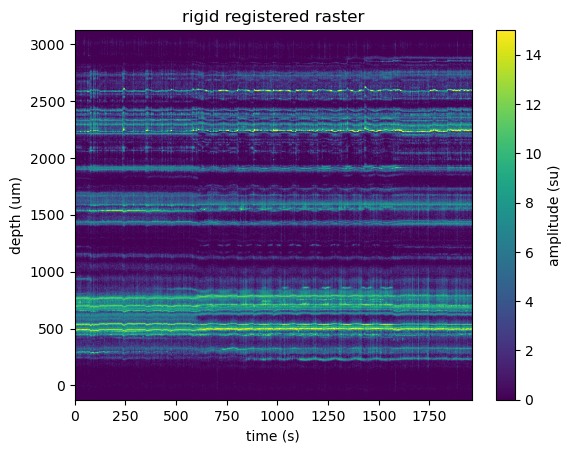

In [31]:
mu.show_registered_raster(motion_est_rigid, amplitude, depth_um, t_seconds, plt, vmax=15, aspect="auto")
plt.colorbar(label="amplitude (su)")
plt.title("rigid registered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)");